## Data Cleaning from json files



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/Othercomputers/My PC/cs7643-project"

Mounted at /content/drive
/content/drive/Othercomputers/My PC/cs7643-project


In [2]:
from classes.PoseDataset import PoseDataset
from models.DNN import DNN
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
from torch.utils.data import DataLoader
import time
from torch import nn

pd.options.display.max_rows = 4000


np.random.seed(123456)
torch.random.manual_seed(123456)

## Training and testing

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.shape[0]

    _, pred = torch.max(output, dim=-1)

    correct = pred.eq(target).sum() * 1.0

    acc = correct / batch_size

    return acc

def train(epoch, data_loader, model, optimizer, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    for idx, (data, target) in enumerate(data_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        #############################################################################
        # TODO: Complete the body of training loop                                  #
        #       1. forward data batch to the model                                  #
        #       2. Compute batch loss                                               #
        #       3. Compute gradients and update model parameters                    #
        #############################################################################
        model.train()
        out = model(data)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        batch_acc = accuracy(out, target)

        losses.update(loss, out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 100 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec @1 {top1.val:.4f} ({top1.avg:.4f})\t')
                  .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses, top1=acc))
            
def validate(epoch, val_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    num_class = 10
    cm = torch.zeros(num_class, num_class)
    # evaluation loop
    for idx, (data, target) in enumerate(val_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        #############################################################################
        # TODO: Complete the body of training loop                                  #
        #       HINT: torch.no_grad()                                               #
        #############################################################################
        model.eval()
        with torch.no_grad():
            out = model(data)
            loss = criterion(out, target)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        batch_acc = accuracy(out, target)

        # update confusion matrix
        _, preds = torch.max(out, 1)
        # for t, p in zip(target.view(-1), preds.view(-1)):
        #     cm[t.long(), p.long()] += 1
        list_of_classes = target.unique().tolist()
        class_acc = {}
        for c in list_of_classes:
            class_acc[c] = ((preds == target) * (target == c)).sum() / (target == c).sum()

        losses.update(loss, out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 100 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
                  .format(epoch, idx, len(val_loader), iter_time=iter_time, loss=losses, top1=acc))
            print(f"\nClass Accuracy:{class_acc}")
    # cm = cm / cm.sum(1)
    # per_cls_acc = cm.diag().detach().numpy().tolist()
    # for i, acc_i in enumerate(per_cls_acc):
    #     print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

    print("* Prec @1: {top1.avg:.4f}".format(top1=acc))
    return acc.avg, cm, class_acc


In [4]:
BATCH_SIZE=32

csv_file_path = "./output/pose_df.csv"
pose_data = pd.read_csv(csv_file_path,index_col=0)
raw_pose_data = pose_data
#[27,33] only have one sample each
pose_data = pose_data[pose_data["Y"] != 27]
pose_data = pose_data[pose_data["Y"] != 33]

#take only the sizes greater than 200
pose_data["size"] = pose_data.groupby('Y').Y.transform('size')
pose_data = pose_data[pose_data['size'] > 250]
pose_data = pose_data.drop(["size"],axis=1)
pose_data = pose_data.reset_index(drop=True)
n_classes = len(pose_data["Y"].unique())
class_remap = {v:i for i,v in enumerate(pose_data["Y"].unique())}
pose_data["Y"] = pose_data["Y"].map(class_remap)
pose_remap = {d['Y']:d["pose"] for d in pose_data[["Y",'pose']].to_dict("records")}
poseName_to_class = {v:k for k,v in pose_remap.items()}
pose_data = pose_data.drop(["pose"],axis=1)



X_train, X_test, y_train, y_test = train_test_split(pose_data.iloc[:,0:-1], pose_data.iloc[:,-1], test_size=0.2, random_state=42,stratify=pose_data.iloc[:,-1])
# 
train_dataset = PoseDataset(x=X_train,y=y_train)
test_dataset = PoseDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=100,shuffle=False, num_workers=2)

In [5]:
print(pose_data.groupby('Y').size())
print(class_remap)
print(pose_remap)


Y
0    371
1    271
2    325
3    485
4    264
5    387
6    300
7    346
8    298
dtype: int64
{1: 0, 4: 1, 7: 2, 9: 3, 21: 4, 37: 5, 50: 6, 63: 7, 64: 8}
{0: 'Boat_Pose_or_Paripurna_Navasana_', 1: 'Bridge_Pose_or_Setu_Bandha_Sarvangasana_', 2: 'Chair_Pose_or_Utkatasana_', 3: 'Cobra_Pose_or_Bhujangasana_', 4: 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_', 5: 'Lord_of_the_Dance_Pose_or_Natarajasana_', 6: 'Seated_Forward_Bend_pose_or_Paschimottanasana_', 7: 'Supta_Baddha_Konasana_', 8: 'Supta_Virasana_Vajrasana'}


In [53]:
pose_data.head(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,Y
0,91.6873,78.0985,73.7965,121.534,65.2808,126.647,147.102,140.269,199.084,139.458,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,80.6215,71.2803,0.000,0.0000,61.8691,84.8607,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,128.4160,141.2390,125.8780,225.640,118.1910,243.557,0.000,0.000,0.000,0.000,129.692,207.728,0.000,0.000,0.00,0.000,210.285,385.541,0.0,0.0,0.0,0.0,0.0,0.0,185.986,386.822,0.0,0.0,0.0,0.0,116.8570,137.4100,0.000,0.0000,97.7038,159.0840,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,223.5800,75.5415,243.3600,113.740,0.0000,0.000,0.000,0.000,0.000,0.000,267.914,121.927,0.000,0.000,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,226.9820,64.6370,232.429,68.0271,0.0000,0.0000,265.877,80.3258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,370.9750,359.5130,384.0880,418.332,382.4080,411.850,320.420,423.215,238.780,413.461,387.363,423.276,322.028,431.370,240.35,415.085,322.026,519.508,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0000,0.0000,382.441,357.8660,0.0000,0.0000,400.357,372.6690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,235.7450,207.0720,227.5630,265.844,213.8770,276.811,0.000,0.000,0.000,0.000,242.618,250.827,357.509,261.766,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,224.8040,202.9260,0.000,0.0000,201.5460,215.2500,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
model = DNN(numClasses=n_classes,hidden_dim=256,features=50)
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(1000):  # loop over the dataset multiple times

    # train loop
    train(epoch, train_dataloader, model, optimizer, criterion)

    # validation loop
    acc, cm,_ = validate(epoch, test_dataloader, model, criterion)


print('Finished Training')

Streaming output truncated to the last 5000 lines.
Epoch: [0][0/7]	Time 0.016 (0.016)	

Class Accuracy:{0: tensor(0.), 1: tensor(0.1429), 2: tensor(0.1111), 3: tensor(0.2105), 4: tensor(0.1667), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.0833), 8: tensor(0.2857)}
* Prec @1: 0.1033
Epoch: [1][0/77]	Time 0.004 (0.004)	Loss 2.1779 (2.1779)	Prec @1 0.1875 (0.1875)	
Epoch: [1][0/7]	Time 0.003 (0.003)	

Class Accuracy:{0: tensor(0.), 1: tensor(0.1429), 2: tensor(0.2222), 3: tensor(0.5789), 4: tensor(0.2500), 5: tensor(0.0833), 6: tensor(0.), 7: tensor(0.0833), 8: tensor(0.1429)}
* Prec @1: 0.1787
Epoch: [2][0/77]	Time 0.009 (0.009)	Loss 2.0625 (2.0625)	Prec @1 0.2812 (0.2812)	
Epoch: [2][0/7]	Time 0.003 (0.003)	

Class Accuracy:{0: tensor(0.), 1: tensor(0.), 2: tensor(0.2222), 3: tensor(0.6842), 4: tensor(0.2500), 5: tensor(0.3333), 6: tensor(0.1000), 7: tensor(0.0833), 8: tensor(0.1429)}
* Prec @1: 0.2262
Epoch: [3][0/77]	Time 0.003 (0.003)	Loss 2.0614 (2.0614)	Prec @1 0.2188 (0.2188)	
Epoch

In [7]:
modelPath = "./models/model_state/poseEstimation.pt"


In [8]:
torch.save(model.state_dict(), modelPath)


## Testing


In [9]:
model = DNN(numClasses=n_classes,hidden_dim=256,features=50)
model.load_state_dict(torch.load(modelPath))
model.eval()

DNN(
  (fc1): Linear(in_features=50, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)

In [10]:
# load the fooling images pose points
fooling_csv_file_path = "./fooling_images/posePoints/fooling_pose_df.csv"
fooling_pose_data = pd.read_csv(fooling_csv_file_path,index_col=0)
X = fooling_pose_data.iloc[:,0:-1]
Y = fooling_pose_data.iloc[:,-1].map(poseName_to_class) # convert pose names to class values
X = torch.FloatTensor(X.to_numpy())
Y = torch.from_numpy(Y.to_numpy()).type(torch.LongTensor)

if torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()


In [13]:
with torch.no_grad():
    out = model(X)

batch_acc = accuracy(out, Y)

# update confusion matrix
_, preds = torch.max(out, 1)

list_of_classes = Y.unique().tolist()
class_acc = {}
for c in list_of_classes:
    class_acc[c] = ((preds == Y) * (Y == c)).sum() / (Y == c).sum()

print(batch_acc)

tensor(0.6143)


In [14]:
class_acc

{0: tensor(0.8750),
 1: tensor(0.4000),
 2: tensor(0.6667),
 3: tensor(0.7500),
 4: tensor(0.4444),
 5: tensor(0.7500),
 6: tensor(0.3333),
 7: tensor(0.5000),
 8: tensor(0.6667)}

In [25]:
criterion = nn.CrossEntropyLoss()

# validation loop
acc, cm,_ = validate(100, test_dataloader, model, criterion)

{0: tensor(0.7500), 1: tensor(0.7143), 2: tensor(0.8889), 3: tensor(0.8421), 4: tensor(1.), 5: tensor(0.8333), 6: tensor(0.5000), 7: tensor(0.5000), 8: tensor(0.7143)}

Epoch: [100][0/7]	Time 0.003 (0.003)	

Class Accuracy:{0: tensor(0.7500), 1: tensor(0.7143), 2: tensor(0.8889), 3: tensor(0.8421), 4: tensor(1.), 5: tensor(0.8333), 6: tensor(0.5000), 7: tensor(0.5000), 8: tensor(0.7143)}
* Prec @1: 0.7213


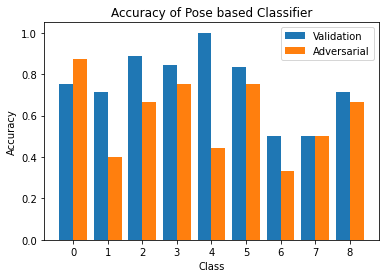

In [26]:
valid_class_ac = {0: (0.7500), 1: (0.7143), 2: (0.8889), 3: (0.8421), 4: (1.), 5: (0.8333), 6: (0.5000), 7: (0.5000), 8: (0.7143)}

import numpy as np 
import matplotlib.pyplot as plt 
  
X = valid_class_ac.keys()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, valid_class_ac.values(), 0.4, label = 'Validation')
plt.bar(X_axis + 0.2, class_acc.values(), 0.4, label = 'Adversarial')
  
plt.xticks(X_axis, X)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy of Pose based Classifier")
plt.legend()
plt.show()

In [22]:
valid_class_ac

{0: tensor(1.),
 1: tensor(1.),
 4: tensor(1.),
 5: tensor(0.5000),
 7: tensor(1.),
 8: tensor(1.)}